<a href="https://colab.research.google.com/github/beatricekiplagat/Deepfake-Audio-Recognition/blob/dev_branch/DEEPFAKE_AUDIO_DETECTION_TRANSFER_LEARNING_MODELS_EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset Preperation

In [2]:
import numpy as np
import tensorflow as tf

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

dataset_path = os.listdir('/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Train')

print (dataset_path)  #what kinds of classes are in this dataset

print("Types of classes labels found: ", len(dataset_path))

class_labels = []

for item in dataset_path:
 # Get all the file names
 all_classes = os.listdir('/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Train' + '/' +item)
 #print(all_classes)

 # Add them to the list
 for room in all_classes:
    class_labels.append((item, str('dataset_path' + '/' +item) + '/' + room))
    #print(class_labels[:5])
    
    
# Build a dataframe        
df = pd.DataFrame(data=class_labels, columns=['Labels', 'image'])
print(df.head())
print(df.tail())

['Spoof', 'Bonafide']
Types of classes labels found:  2
  Labels                                image
0  Spoof  dataset_path/Spoof/LA_D_7121651.png
1  Spoof  dataset_path/Spoof/LA_D_7212590.png
2  Spoof  dataset_path/Spoof/LA_D_6131320.png
3  Spoof  dataset_path/Spoof/LA_D_6692719.png
4  Spoof  dataset_path/Spoof/LA_D_8380959.png
        Labels                                           image
1645  Bonafide  dataset_path/Bonafide/Copy of LA_D_5945817.png
1646  Bonafide  dataset_path/Bonafide/Copy of LA_D_1696066.png
1647  Bonafide  dataset_path/Bonafide/Copy of LA_D_5226379.png
1648  Bonafide  dataset_path/Bonafide/Copy of LA_D_3440131.png
1649  Bonafide  dataset_path/Bonafide/Copy of LA_D_8126437.png


In [3]:

# Let's check how many samples for each category are present
print("Total number of images in the dataset: ", len(df))

label_count = df['Labels'].value_counts()
print(label_count)

Total number of images in the dataset:  1650
Bonafide    851
Spoof       799
Name: Labels, dtype: int64


In [5]:
import cv2
path = '/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Train/'
dataset_path = os.listdir('/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Train')

im_size = 224

images = []
labels = []

for i in dataset_path:
    data_path = path + str(i)  
    filenames = [i for i in os.listdir(data_path) ]
   
    for f in filenames:
        img = cv2.imread(data_path + '/' + f)
        img = cv2.resize(img, (im_size, im_size))
        images.append(img)
        labels.append(i)

In [6]:
#This model takes input images of shape (224, 224, 3), and the input data should range [0, 255]. 

images = np.array(images)

images = images.astype('float32') / 255.0
images.shape

(1650, 224, 224, 3)

In [7]:
#Pre-processing the data. We need to perform label encoding in order to get the model to work
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
y=df['Labels'].values
print(y)

y_labelencoder = LabelEncoder ()
y = y_labelencoder.fit_transform (y)
print (y)

['Spoof' 'Spoof' 'Spoof' ... 'Bonafide' 'Bonafide' 'Bonafide']
[1 1 1 ... 0 0 0]


In [8]:
y=y.reshape(-1,1)

from sklearn.compose import ColumnTransformer
ct = ColumnTransformer([('my_ohe', OneHotEncoder(), [0])], remainder='passthrough')
Y = ct.fit_transform(y) #.toarray()
print(Y[:5])
print(Y[35:])

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [9]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


images, Y = shuffle(images, Y, random_state=1)


train_x, test_x, train_y, test_y = train_test_split(images, Y, test_size=0.05, random_state=415)

#inpect the shape of the training and testing.
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(1567, 224, 224, 3)
(1567, 2)
(83, 224, 224, 3)
(83, 2)


EfficientNet Implementation :

In [12]:
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0

NUM_CLASSES = 2
IMG_SIZE = 224
size = (IMG_SIZE, IMG_SIZE)


inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))


# Using model without transfer learning

outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(inputs)

In [13]:
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"] )

model.summary()

hist = model.fit(train_x, train_y, epochs=30, verbose=2)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 2)                 4052133   
Total params: 4,052,133
Trainable params: 4,010,110
Non-trainable params: 42,023
_________________________________________________________________
Epoch 1/30
49/49 - 337s - loss: 1.3833 - accuracy: 0.6477
Epoch 2/30
49/49 - 323s - loss: 0.4650 - accuracy: 0.8200
Epoch 3/30
49/49 - 322s - loss: 0.3731 - accuracy: 0.8500
Epoch 4/30
49/49 - 325s - loss: 0.3332 - accuracy: 0.8800
Epoch 5/30
49/49 - 326s - loss: 0.1775 - accuracy: 0.9317
Epoch 6/30
49/49 - 328s - loss: 0.2019 - accuracy: 0.9311
Epoch 7/30
49/49 - 326s - loss: 0.1046 - accuracy: 0.9611
Epoch 8/30
49/49 - 324s - loss: 0.1204 - accuracy: 0.9611
Epoch 9/30
49/49 - 325s - loss: 0.0926 - acc

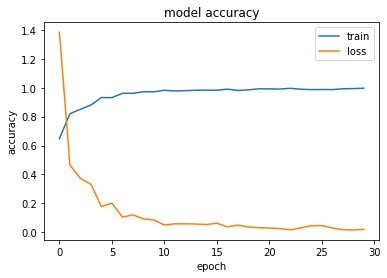

In [29]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["loss"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "loss"], loc="upper right")
    plt.show()


plot_hist(hist)

In [15]:
preds = model.evaluate(test_x, test_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

3/3 [==============================] - 5s 963ms/step - loss: 0.3273 - accuracy: 0.9157
Loss = 0.32728710770606995
Test Accuracy = 0.9156626462936401


TESTING MODEL ON UNSEEN DATA :

Input image shape: (1, 224, 224, 3)


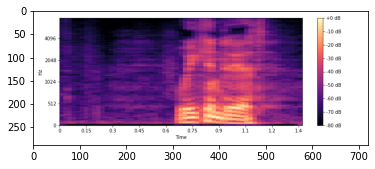

In [36]:
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input


img_path = '/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Test/Bonafide/LA_D_1556595.png'

#img = image.load_img(img_path, target_size=(224, 224))
#x = img.img_to_array(img)

img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))

x = np.expand_dims(img, axis=0)
x = preprocess_input(x)

print('Input image shape:', x.shape)

my_image = imread(img_path)
imshow(my_image)

In [37]:
preds=model.predict(x)
preds     # probabilities for being in each of the 2 classes

array([[0., 1.]], dtype=float32)